In [1]:
import pandas as pd
import numpy as np
import time
import sys

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression  
from sklearn import svm

module_path='/Users/DAHS/Desktop/ECP_CONT/ECP_SCL/Experiment(Supervised Learning)/evaluation/'
if module_path not in sys.path:
    sys.path.append(module_path)
    
from integrating_embedding import *

import integrating_embedding
from imp import reload
reload(integrating_embedding)

module_path='/Users/DAHS/Desktop/ECP_CONT/ECP_SCL/Experiment(Supervised Learning)/evaluation/'
if module_path not in sys.path:
    sys.path.append(module_path)

import get_hospital_eicu


emb_path_trn_mimic = '/Users/DAHS/Desktop/ECP_CONT/ECP_SCL/Cohort_selection/Train/result/emb_train_new_version(0303).npy'
emb_path_vld_mimic = '/Users/DAHS/Desktop/ECP_CONT/ECP_SCL/Cohort_selection/Train/result/emb_valid_new_version(0303).npy'
# emb_path_event_mimic = '/Users/DAHS/Desktop/ECP_CONT/ECP_SCL/Cohort_selection/Train/result/emb_event_new_version(0303).npy'

emb_path_trn_eicu = '/Users/DAHS/Desktop/ECP_CONT/ECP_SCL/Cohort_selection/Train/result/emb_eicu_new_version(0303).npy'

mimic_path = '/Users/DAHS/Desktop/ECP_CONT/ECP_SCL/Case Labeling/mimic_analysis(new_version0229).csv.gz'
eicu_path = '/Users/DAHS/Desktop/ECP_CONT/ECP_SCL/Case Labeling/eicu_analysis(new_version0229).csv.gz'

mimic_train_emb, mimic_valid_emb, event = integrating_embedding.integrating(mimic_path, emb_path_trn_mimic, emb_path_vld_mimic, _, 'mimic')
eicu_test_emb, event_eicu, hosp_id = integrating_embedding.integrating(eicu_path, emb_path_trn_eicu, _, _, 'eicu')
eicu_type = get_hospital_eicu.eicu_subgroup(eicu_test_emb)
unitadmitsource, unittype, unitstaytype = get_hospital_eicu.make_eicu_dataset(eicu_type)

c:\Users\DAHS\anaconda3\envs\DL\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


========== 데이터셋 분할 정보 ==========
데이터셋 비율: 학습 = 0.90, 테스트 = 0.10
학습셋 클래스 비율: Case
1.0    473941
2.0      5128
3.0     15571
4.0     15705
Name: count, dtype: int64
테스트셋 클래스 비율: Case
1.0    53103
2.0      512
3.0     1253
4.0     1271
Name: count, dtype: int64
--------------------------------------
========== 클래스 비율 ==========
학습셋 클래스 비율: 0.93:0.01:0.03:0.03
테스트셋 클래스 비율: 0.95:0.01:0.02:0.02
--------------------------------------
========== 환자 및 체류 정보 ==========
학습셋 환자 수: 2907
테스트셋 환자 수: 329
학습셋 체류 수: 2961
테스트셋 체류 수: 330
--------------------------------------
========== 실험 설정 ==========
분할 시드: 9040
학습 비율: 0.9
임계값: 0.05
--------------------------------------
========== 실행 결과 ==========
총 소요 시간(초): 0.40
시도한 시행 횟수: 0


In [2]:
module_path='/Users/DAHS/Desktop/ECP_CONT/ECP_SCL/Experiment(Supervised Learning)/evaluation/'
if module_path not in sys.path:
    sys.path.append(module_path)

import split
from imp import reload
reload(split)

import Multiclass_evaluation
reload(Multiclass_evaluation)

<module 'Multiclass_evaluation' from 'c:\\Users/DAHS/Desktop/ECP_CONT/ECP_SCL/Experiment(Supervised Learning)/evaluation\\Multiclass_evaluation.py'>

In [3]:
X_train, y_train, output = split.split_X_Y(mimic_train_emb, mode = 'mimic')
X_valid, y_valid, valid_output = split.split_X_Y(mimic_valid_emb, mode = 'mimic')

In [4]:
valid_event = event[event.stay_id.isin(mimic_valid_emb.stay_id.unique())]

In [5]:
len(valid_event)

64

In [14]:
from sklearn.ensemble import RandomForestClassifier

sampler = TPESampler(seed=10)

def objective(trial):

    param = {
        'verbose': 0,
        'criterion': 'log_loss', 
        'class_weight':'balanced',
        'n_estimators': trial.suggest_int('n_estimators', 10, 100),
        'min_samples_split': trial.suggest_int('min_samples_split', 1, 150),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 60),
        'random_state':trial.suggest_int('random_state', 10, 100),
    }

    model = RandomForestClassifier(**param)
    rf_model = model.fit(X_train, y_train)
    valid_preds = rf_model.predict(X_valid)
    valid_output['prediction_label'] = valid_preds
    valid_output['prediction_prob'] = rf_model.predict_proba(X_valid)[:, 1]
    report = classification_report(valid_output.Case, valid_output.prediction_label, output_dict=True)
    report_int_keys = {int(float(k)): v for k, v in report.items() if k not in ['accuracy', 'macro avg', 'weighted avg']}
    case2_precision = np.round(report_int_keys[2]['precision'], 4)
    
    event_for = valid_output[valid_output['INDEX']=='CASE1_CASE2_DF']
    event_for['prediction_label'] = event_for['prediction_label'].replace({1:0, 2:1, 3:1, 4:1})
    event_for['Case'] = event_for['Case'].replace({1:0, 2:1, 3:1, 4:1})
    
    result = classifier_ML.event_metric(event, event_for, 'mimic', 'rf')
    case2_recall_event = result['recall'].values[0]
    
    f1_score = (2*case2_precision*case2_recall_event)/(case2_precision+case2_recall_event)
    
    return f1_score
        
study_rf = optuna.create_study(direction='maximize', sampler=sampler)
study_rf.optimize(objective, n_trials=100)
print('Random Forest Best parameters:', study_rf.best_params)

[I 2024-03-03 18:14:24,423] A new study created in memory with name: no-name-bddc2391-64c5-4c45-9767-74702890867b
[W 2024-03-03 18:16:44,133] Trial 0 failed with parameters: {'n_estimators': 80, 'min_samples_split': 4, 'min_samples_leaf': 39, 'random_state': 78} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\DAHS\anaconda3\envs\DL\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\DAHS\AppData\Local\Temp\ipykernel_43052\2621967197.py", line 77, in objective
    rf_model = model.fit(X_train, y_train)
  File "c:\Users\DAHS\anaconda3\envs\DL\lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\DAHS\anaconda3\envs\DL\lib\site-packages\sklearn\ensemble\_forest.py", line 456, in fit
    trees = Parallel(
  File "c:\Users\DAHS\anaconda3\envs\DL\lib\site-packages\sklearn\utils\parallel.py", line 6

KeyboardInterrupt: 

In [8]:
print('LightGBM Best parameters:', study_lgb.best_params)

LightGBM Best parameters: {'lambda_l1': 0.0012731996741265673, 'lambda_l2': 0.002609666442060576, 'learning_rate': 0.009988382649977619, 'n_estimators': 97, 'min_child_samples': 79, 'subsample': 0.6014906937195785, 'random_state': 31}


In [5]:
reload(Multiclass_evaluation) #no tuning
models, result = Multiclass_evaluation.create_analysis(event, X_train, y_train, X_valid, valid_output, mode = 'emb')

|MIMIC-Validation|====================================================


,Model,Accuracy,Case 1 AUROC,Case 1 AUPRC,Case 2 AUROC,Case 2 AUPRC,Case 3 AUROC,Case 3 AUPRC,Case 4 AUROC,Case 4 AUPRC,Case 1 Score,Case 2 Score,Case 3 Score,Case 4 Score
0,lgbm,0.988653,0.9253,0.9958,0.5592,0.3626,0.9835,0.9446,0.9579,0.9430,0.9954,0.5388,0.9436,0.9414
1,rf,0.987602,0.9276,0.9959,0.5745,0.3275,0.9703,0.9290,0.9557,0.9281,0.9952,0.6245,0.9281,0.9269
2,dt,0.970537,0.9285,0.9959,0.6196,0.1932,0.9142,0.8606,0.9457,0.8703,0.9876,0.6085,0.8578,0.8684
3,lr,0.988261,0.9230,0.9956,0.5447,0.3730,0.9720,0.9346,0.9600,0.9341,0.9954,0.4069,0.9338,0.9331


----------------------------------------------------------------------


In [16]:
reload(Multiclass_evaluation)

X_train, y_train, output = split.split_X_Y(mimic_train_emb[mimic_train_emb['stay_id'].isin(event.stay_id.unique())], mode = 'mimic')
X_valid, y_valid, valid_output = split.split_X_Y(mimic_valid_emb, mode = 'mimic')

models, result = Multiclass_evaluation.create_analysis(event, X_train, y_train, X_valid, valid_output, mode = 'emb')

|MIMIC-Validation|====================================================


,Model,Accuracy,Case 1 AUROC,Case 1 AUPRC,Case 2 AUROC,Case 2 AUPRC,Case 3 AUROC,Case 3 AUPRC,Case 4 AUROC,Case 4 AUPRC,Case 1 Score,Case 2 Score,Case 3 Score,Case 4 Score
0,lgbm,0.987549,0.9336,0.9962,0.6138,0.3280,0.9851,0.9463,0.9580,0.9447,0.9948,0.4696,0.9453,0.9429
1,rf,0.976416,0.9356,0.9963,0.6550,0.2521,0.9644,0.9258,0.9591,0.9261,0.9893,0.4683,0.9250,0.9252
2,dt,0.835640,0.8681,0.9922,0.6193,0.2105,0.9107,0.8598,0.9488,0.8711,0.9093,0.1036,0.8564,0.8688
3,lr,0.982793,0.9375,0.9964,0.6503,0.2887,0.9720,0.9346,0.9600,0.9341,0.9925,0.4973,0.9338,0.9331


----------------------------------------------------------------------


In [18]:
result.to_excel(excel_writer='internal_validation_proposed_method.xlsx')

In [ ]:
reload(Multiclass_evaluation)

X_train, y_train, output = split.split_X_Y(mimic_train_emb[mimic_train_emb['stay_id'].isin(event.stay_id.unique())], mode = 'mimic')
X_valid, y_valid, valid_output = split.split_X_Y(mimic_valid_emb[mimic_valid_emb['stay_id'].isin(event.stay_id.unique())], mode = 'mimic')

models, result = Multiclass_evaluation.create_analysis(event, X_train, y_train, X_valid, valid_output, mode = 'emb')

In [15]:
def number(df, mode):
    
    if mode == 'mimic':
        print('number of subject :', len(df.drop_duplicates(subset=["subject_id"])))
        print('number of stay :', len(df.drop_duplicates(subset=["stay_id"])))
        
    else:
        print('number of subject :', len(df.drop_duplicates(subset=["uniquepid"])))
        print('number of stay :', len(df.drop_duplicates(subset=["patientunitstayid"])))

number(event, 'mimic')
number(event_eicu, 'eicu')

number of subject : 699
number of stay : 705
number of subject : 791
number of stay : 791


In [7]:
#optuna
import optuna
from optuna.samplers import TPESampler
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report

module_path='/Users/DAHS/Desktop/ECP_CONT/ECP_SCL/Experiment(Supervised Learning)/evaluation/'
if module_path not in sys.path:
    sys.path.append(module_path)
    
import classifier_ML
reload(classifier_ML)

sampler = TPESampler(seed=10)

X_train, y_train, output = split.split_X_Y(mimic_train_emb[mimic_train_emb['stay_id'].isin(event.stay_id.unique())], mode = 'mimic')
X_valid, y_valid, valid_output = split.split_X_Y(mimic_valid_emb, mode = 'mimic')

def objective(trial):

    param = {
        'objective': 'multiclass',
        'verbose': -1,
        'metric': 'multi_logloss', 
        "num_class": 4,
        'max_depth': trial.suggest_int('max_depth',10, 100),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        # 'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1e-2),
        'n_estimators': trial.suggest_int('n_estimators', 9, 11),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
        # 'random_state':trial.suggest_int('random_state', 10, 100),
    }

    model = LGBMClassifier(**param, early_stopping_rounds=25, extra_trees = True, random_state =42)
    lgb_model = model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])
    valid_preds = lgb_model.predict(X_valid)
    valid_output['prediction_label'] = valid_preds
    valid_output['prediction_prob'] = lgb_model.predict_proba(X_valid)[:, 1]
    
    result = Multiclass_evaluation.MULT_evaluation(valid_output, event, 'lgbm', 'mimic')
    
    return result['Case 2 Score'].values[0]
        
study_lgb = optuna.create_study(direction='maximize', sampler=sampler)
study_lgb.optimize(objective, n_trials=30)
print('LightGBM Best parameters:', study_lgb.best_params)

[I 2024-03-03 20:55:15,216] A new study created in memory with name: no-name-3784378f-bbd6-4f22-9182-011eab9d65b0
[I 2024-03-03 20:55:16,738] Trial 0 finished with value: 0.4768 and parameters: {'max_depth': 80, 'lambda_l1': 1.537331564587801e-08, 'lambda_l2': 0.005044685709888605, 'n_estimators': 11, 'min_child_samples': 52, 'subsample': 0.49149100090271824}. Best is trial 0 with value: 0.4768.
[I 2024-03-03 20:55:18,140] Trial 1 finished with value: 0.5052 and parameters: {'max_depth': 28, 'lambda_l1': 0.0699481785242808, 'lambda_l2': 3.32657660618516e-07, 'n_estimators': 9, 'min_child_samples': 70, 'subsample': 0.9581937809264416}. Best is trial 1 with value: 0.5052.
[I 2024-03-03 20:55:19,678] Trial 2 finished with value: 0.4807 and parameters: {'max_depth': 10, 'lambda_l1': 0.0004071274363191098, 'lambda_l2': 0.20586790968905005, 'n_estimators': 10, 'min_child_samples': 74, 'subsample': 0.5226478358414336}. Best is trial 1 with value: 0.5052.
[I 2024-03-03 20:55:21,041] Trial 3 fi

LightGBM Best parameters: {'max_depth': 57, 'lambda_l1': 0.9490739502172844, 'lambda_l2': 1.4264864106397634e-07, 'n_estimators': 11, 'min_child_samples': 56, 'subsample': 0.6338897631069145}


In [19]:
reload(Multiclass_evaluation)

X_train, y_train, output = split.split_X_Y(mimic_train_emb[mimic_train_emb['stay_id'].isin(event.stay_id.unique())], mode = 'mimic')
X_valid, y_valid, valid_output = split.split_X_Y(mimic_valid_emb, mode = 'mimic')

lgbm_tune = LGBMClassifier(max_depth = 57, lambda_l1 = 0.9490739502172844, lambda_l2 = 1.4264864106397634e-07,
                           n_estimators = 11, min_child_samples = 56, subsample = 0.6338897631069145, extra_trees = True, verbose=-1, random_state =42)

lgbm_tune.fit(X_train, y_train)


valid_preds = lgbm_tune.predict(X_valid)
valid_output['prediction_label'] = valid_preds
valid_output['prediction_prob'] = lgbm_tune.predict_proba(X_valid)[:, 1]
    
result_validation = Multiclass_evaluation.MULT_evaluation(valid_output, event, 'lgbm', 'mimic')
print('Tuned evaluation')
display(result_validation)

result_external = Multiclass_evaluation.external_evaluation(unitadmitsource, unittype, unitstaytype, lgbm_tune, 'LightGBM', event_eicu)

Tuned evaluation


,Model,Accuracy,Case 1 AUROC,Case 1 AUPRC,Case 2 AUROC,Case 2 AUPRC,Case 3 AUROC,Case 3 AUPRC,Case 4 AUROC,Case 4 AUPRC,Case 1 Score,Case 2 Score,Case 3 Score,Case 4 Score
0,lgbm,0.987513,0.9357,0.9963,0.6273,0.3438,0.9835,0.946,0.9595,0.9446,0.9947,0.5601,0.9451,0.9431


[Starting eICU-Test]
eICU-UnitAdmitSource...
eICU-UnitType...
eICU-UnitStayType...
ZeroDivisionError


Model  Accuracy  Case 1 AUROC  \
Subpopulation   eICU Type                                                
UnitAdmitSource Floor                 LightGBM  0.917315        0.9108   
                Emergency Department  LightGBM  0.919293        0.9167   
                Direct Admit          LightGBM  0.927420        0.9202   
                Other Hospital        LightGBM  0.931318        0.9312   
                Other ICU             LightGBM  0.918338        0.8551   
                Step-Down Unit (SDU)  LightGBM  0.930153        0.8921   
                Operating Room        LightGBM  0.900349        0.9110   
                Recovery Room         LightGBM  0.958071        0.9631   
                Acute Care/Floor      LightGBM  0.901694        0.8812   
                Chest Pain Center     LightGBM  0.822581        0.8197   
                PACU                  LightGBM  0.930344        0.9326   
                ICU                   LightGBM  0.954277        0.8494   
UnitType        Med-Surg ICU          LightGBM  0.922037        0.9151   
                Neuro ICU             LightGBM  0.921011        0.8998   
                Cardiac ICU           LightGBM  0.929618        0.9081   
                SICU                  LightGBM  0.930131        0.9441   
                CTICU                 LightGBM  0.900431        0.8899   
                CCU-CTICU             LightGBM  0.906298        0.8969   
                MICU                  LightGBM  0.926786        0.9208   
                CSICU                 LightGBM  0.902601        0.9038   
UnitStayType    admit                 LightGBM  0.919278        0.9144   
                transfer              LightGBM  0.926166        0.9151   
                readmit               LightGBM  0.917188        0.9106   
                stepdown/other        LightGBM  0.907216        0.5000   

                                      Case 1 AUPRC  Case 2 AUROC  \
Subpopulation   eICU Type                                          
UnitAdmitSource Floor                       0.9584        0.5883   
                Emergency Department        0.9591        0.5860   
                Direct Admit                0.9669        0.6003   
                Other Hospital              0.9678        0.5935   
                Other ICU                   0.9647        0.5442   
                Step-Down Unit (SDU)        0.9672        0.5629   
                Operating Room              0.9429        0.5604   
                Recovery Room               0.9768        0.6425   
                Acute Care/Floor            0.9578        0.5865   
                Chest Pain Center           0.8999        0.4861   
                PACU                        0.9285        0.6318   
                ICU                         0.9813        0.5670   
UnitType        Med-Surg ICU                0.9591        0.5795   
                Neuro ICU                   0.9590        0.5516   
                Cardiac ICU                 0.9680        0.5505   
                SICU                        0.9620        0.6164   
                CTICU                       0.9599        0.5841   
                CCU-CTICU                   0.9590        0.6050   
                MICU                        0.9651        0.5973   
                CSICU                       0.9543        0.5758   
UnitStayType    admit                       0.9601        0.5842   
                transfer                    0.9649        0.5855   
                readmit                     0.9568        0.5719   
                stepdown/other              0.9583        0.4944   

                                      Case 2 AUPRC Case 3 AUROC Case 3 AUPRC  \
Subpopulation   eICU Type                                                      
UnitAdmitSource Floor                       0.3313       0.9775       0.9499   
                Emergency Department        0.3163       0.9773       0.9517   
                Direct Admi

In [20]:
result_external.to_excel(excel_writer='external_validation_proposed_method.xlsx')

In [13]:
eicu_type = get_hospital_eicu.eicu_subgroup(eicu_test_emb)
unitadmitsource, unittype, unitstaytype = get_hospital_eicu.make_eicu_dataset(eicu_type[eicu_type.patientunitstayid.isin(event_eicu.patientunitstayid.unique())])

In [14]:
result_only_event = Multiclass_evaluation.external_evaluation(unitadmitsource, unittype, unitstaytype, lgbm_tune, 'LightGBM', event_eicu)

[Starting eICU-Test]
eICU-UnitAdmitSource...
eICU-UnitType...
eICU-UnitStayType...
ZeroDivisionError


Model  Accuracy  Case 1 AUROC  \
Subpopulation   eICU Type                                                
UnitAdmitSource Floor                 LightGBM  0.917315        0.9108   
                Emergency Department  LightGBM  0.919293        0.9167   
                Direct Admit          LightGBM  0.927420        0.9202   
                Other Hospital        LightGBM  0.931318        0.9312   
                Other ICU             LightGBM  0.918338        0.8551   
                Step-Down Unit (SDU)  LightGBM  0.930153        0.8921   
                Operating Room        LightGBM  0.900349        0.9110   
                Recovery Room         LightGBM  0.958071        0.9631   
                Acute Care/Floor      LightGBM  0.901694        0.8812   
                Chest Pain Center     LightGBM  0.822581        0.8197   
                PACU                  LightGBM  0.930344        0.9326   
                ICU                   LightGBM  0.954277        0.8494   
UnitType        Med-Surg ICU          LightGBM  0.922037        0.9151   
                Neuro ICU             LightGBM  0.921011        0.8998   
                Cardiac ICU           LightGBM  0.929618        0.9081   
                SICU                  LightGBM  0.930131        0.9441   
                CTICU                 LightGBM  0.900431        0.8899   
                CCU-CTICU             LightGBM  0.906298        0.8969   
                MICU                  LightGBM  0.926786        0.9208   
                CSICU                 LightGBM  0.902601        0.9038   
UnitStayType    admit                 LightGBM  0.919278        0.9144   
                transfer              LightGBM  0.926166        0.9151   
                readmit               LightGBM  0.917188        0.9106   
                stepdown/other        LightGBM  0.907216        0.5000   

                                      Case 1 AUPRC  Case 2 AUROC  \
Subpopulation   eICU Type                                          
UnitAdmitSource Floor                       0.9584        0.5883   
                Emergency Department        0.9591        0.5860   
                Direct Admit                0.9669        0.6003   
                Other Hospital              0.9678        0.5935   
                Other ICU                   0.9647        0.5442   
                Step-Down Unit (SDU)        0.9672        0.5629   
                Operating Room              0.9429        0.5604   
                Recovery Room               0.9768        0.6425   
                Acute Care/Floor            0.9578        0.5865   
                Chest Pain Center           0.8999        0.4861   
                PACU                        0.9285        0.6318   
                ICU                         0.9813        0.5670   
UnitType        Med-Surg ICU                0.9591        0.5795   
                Neuro ICU                   0.9590        0.5516   
                Cardiac ICU                 0.9680        0.5505   
                SICU                        0.9620        0.6164   
                CTICU                       0.9599        0.5841   
                CCU-CTICU                   0.9590        0.6050   
                MICU                        0.9651        0.5973   
                CSICU                       0.9543        0.5758   
UnitStayType    admit                       0.9601        0.5842   
                transfer                    0.9649        0.5855   
                readmit                     0.9568        0.5719   
                stepdown/other              0.9583        0.4944   

                                      Case 2 AUPRC Case 3 AUROC Case 3 AUPRC  \
Subpopulation   eICU Type                                                      
UnitAdmitSource Floor                       0.3313       0.9775       0.9499   
                Emergency Department        0.3163       0.9773       0.9517   
                Direct Admi

In [ ]:
# class 갯수가 많은 애들은 contrastive 쓰나 마나 똑같음 -> 원본데이터로도 충분히 정보가 있음
# 하지만 contrastive 를 씀으로써 맞추기 힘든 case 2를 잘 맞출 수 있게 됨 -> 모든 모델에서 모두 상승함
# contastive learning이 데이터 불균형 상황이더라도, 소수 클래스에 대해서 적합을 잘할 수 있음

# 이를 바탕으로 쇼크 모니터링 시스템을 개발함
# 베스 이스라엘 뿐 아니라, 다른 다양한 병원에서도 잘 적합하는 시스템을 개발하기 위해 본 연구에서는 eicu 데이터를 활용
# 따라서 eicu 2014를 이용해 시스템을 개발하고, 성능 평가를 위해 2015 데이터를 활용
# 가장 성능이 좋았던 모델을 기반으로 시스템을 개발

In [576]:
mimic_train_emb[mimic_train_emb['Annotation']=='ambiguous'].Case.value_counts().sort_index()

1.0    79092
2.0     3224
3.0     8000
4.0     8704
Name: Case, dtype: int64

In [577]:
mimic_train_emb[mimic_train_emb['Annotation']=='circ'].Case.value_counts().sort_index()

3.0     3145
4.0    10909
Name: Case, dtype: int64

### Tracking system

In [322]:
#tracking system
reload(split)

X_viz, y_train_viz, output_viz = split.split_X_Y_for_VIZ(mimic_train_emb, mode = 'mimic')

lgbm_wrapper = LGBMClassifier(n_estimators=10, random_state=42, extra_trees = True, verbose=-1)
lgbm_wrapper.fit(X_viz, y_train_viz)

preds = lgbm_wrapper.predict(X_viz)
output_viz['prediction_label'] = preds
output_viz['prediction_prob_case2'] = lgbm_wrapper.predict_proba(X_viz)[:, 1]
output_viz['prediction_prob_case4'] = lgbm_wrapper.predict_proba(X_viz)[:, 3]

In [179]:
from sklearn.metrics import classification_report

In [390]:
def min_max_scaling(column, min_value, max_value):
    
    if (min_value == 'none') & (max_value == 'none'):
        min_value = column.min()
        max_value = column.max()
        scaled_column = (column - min_value) / (max_value - min_value)
        return scaled_column, min_value, max_value
    
    else:
        scaled_column = (column - min_value) / (max_value - min_value)
        return scaled_column

In [324]:
f1_scores = {}

# 유니크한 stay_id 별로 반복
for stay_id in output_viz['stay_id'].unique():
    interest = output_viz[output_viz['stay_id'] == stay_id]
    interest
    report = classification_report(interest.Case, interest.prediction_label, output_dict=True)
    report_int_keys = {int(float(k)): v for k, v in report.items() if k not in ['accuracy', 'macro avg', 'weighted avg']}
    if 3 in interest.Case.values:
        case34_f1 = np.round(report_int_keys[3]['f1-score'], 4) if 3 in report_int_keys else np.nan
    else:
        case34_f1 = np.nan
        
    if 2 in interest.Case.values:
        case2_f1 = np.round(report_int_keys[2]['f1-score'], 4) if 2 in report_int_keys else np.nan
    else:
        case2_f1 = np.nan

    f1_scores[stay_id] = (case34_f1 + case2_f1) / 2

high_f1_stay_ids = [stay_id for stay_id, f1 in f1_scores.items() if f1 >= 0.9]

In [191]:
high_f1_stay_ids

[36438264,
 34063284,
 37545217,
 32367987,
 36226794,
 31885285,
 30690523,
 36932912,
 35114774,
 32026706,
 32821521,
 32551329,
 39817695,
 33150173,
 30201512,
 36181972,
 31766968,
 31308486,
 33922130,
 32620013]

In [298]:
interest = output_viz[output_viz['stay_id'] == high_f1_stay_ids[2]]
interest

,stay_id,Time_since_ICU_admission,vasoactive/inotropic,Fluids(ml),Annotation,progress,Case,INDEX,Lactate_clearance_3h,prediction_label,prediction_prob_case2,prediction_prob_case4
76447,37545217,0,0,2.498250e+06,no_circ,0,1,CASE1_CASE2_DF,0.0,1.0,0.002392,0.008812
76448,37545217,1,0,2.498250e+06,no_circ,0,1,CASE1_CASE2_DF,0.0,1.0,0.002392,0.008812
76449,37545217,2,0,2.498250e+06,no_circ,0,1,CASE1_CASE2_DF,0.0,1.0,0.002357,0.008684
76450,37545217,3,0,2.498250e+06,no_circ,0,1,CASE1_CASE2_DF,0.0,1.0,0.002375,0.008812
76451,37545217,4,0,2.498250e+06,no_circ,0,1,CASE1_CASE2_DF,0.0,1.0,0.002375,0.008812
...,...,...,...,...,...,...,...,...,...,...,...,...
485085,37545217,123,1,2.430117e+05,ambiguous,1,4,CASE3_CASE4_DF,0.0,4.0,0.005658,0.841680
485086,37545217,124,1,5.186293e+05,ambiguous,1,4,CASE3_CASE4_DF,0.0,4.0,0.005658,0.841680
485087,37545217,125,1,5.185244e+05,ambiguous,1,4,CASE3_CASE4_DF,0.0,4.0,0.005661,0.842070
485088,37545217,126,1,5.185243e+05,ambiguous,1,4,CASE3_CASE4_DF,0.0,4.0,0.005658,0.841680


In [299]:
interest[interest['Case']==2]

,stay_id,Time_since_ICU_admission,vasoactive/inotropic,Fluids(ml),Annotation,progress,Case,INDEX,Lactate_clearance_3h,prediction_label,prediction_prob_case2,prediction_prob_case4
76493,37545217,46,0,2.490480e+06,no_circ,0,2,CASE1_CASE2_DF,0.0,2.0,0.576098,0.019566
76494,37545217,47,0,2.490499e+06,no_circ,0,2,CASE1_CASE2_DF,0.0,2.0,0.584286,0.019844
76495,37545217,48,0,2.490499e+06,no_circ,0,2,CASE1_CASE2_DF,0.0,2.0,0.553097,0.018785
76496,37545217,49,0,2.490249e+06,no_circ,0,2,CASE1_CASE2_DF,0.0,2.0,0.555983,0.018664
76497,37545217,50,0,2.490249e+06,no_circ,0,2,CASE1_CASE2_DF,0.0,2.0,0.555983,0.018664
76498,37545217,51,1,2.490264e+06,ambiguous,0,2,CASE1_CASE2_DF,0.0,2.0,0.562854,0.016932
76499,37545217,52,1,2.490264e+06,ambiguous,0,2,CASE1_CASE2_DF,0.0,2.0,0.524726,0.015785
76500,37545217,53,1,2.490299e+06,ambiguous,0,2,CASE1_CASE2_DF,0.0,2.0,0.567217,0.017063


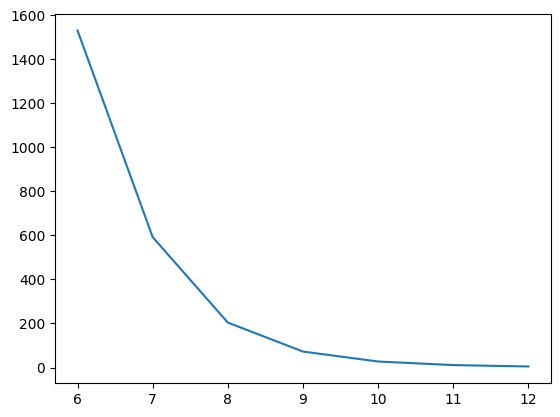

In [330]:
import matplotlib.pyplot as plt
import numpy as np

T = np.array([6, 7, 8, 9, 10, 11, 12])
power = np.array([1.53E+03, 5.92E+02, 2.04E+02, 7.24E+01, 2.72E+01, 1.10E+01, 4.70E+00])

plt.plot(T,power)
plt.show()

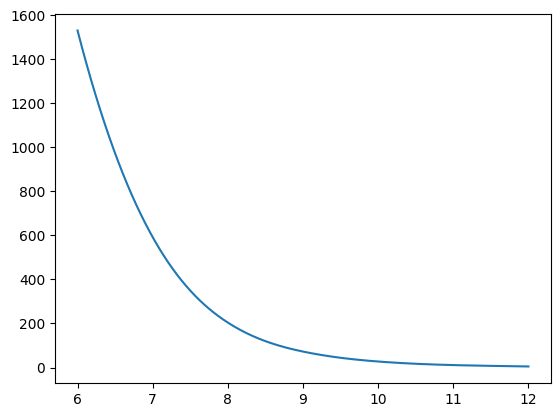

In [332]:
from scipy.interpolate import make_interp_spline, BSpline

# 300 represents number of points to make between T.min and T.max
xnew = np.linspace(T.min(), T.max(), 300) 

spl = make_interp_spline(T, power, k=3)  # type: BSpline
power_smooth = spl(xnew)

plt.plot(xnew, power_smooth)
plt.show()

In [342]:
power.shape

(7,)

In [343]:
T.shape

(7,)

In [344]:
Case1_2['Time_since_ICU_admission'].values.shape

(22,)

In [345]:
interest['MAP_scaled'].values.shape

(69,)

In [378]:
mimic = pd.read_csv('/Users/DAHS/Desktop/ECP_CONT/ECP_SCL/Case Labeling/MIMIC-IV.csv.gz', compression ='gzip')

In [408]:
mimic[mimic['stay_id']==36438264][['Time_since_ICU_admission', 'Annotation','Lactate', 'MAP']].sort_values(by=["Time_since_ICU_admission"]).iloc[32:]

,Time_since_ICU_admission,Annotation,Lactate,MAP
190985,32,circ,2.6,72.666667
190986,71,no_circ,1.6,84.000000
190987,72,no_circ,1.1,82.333333
190988,73,no_circ,1.1,81.000000
190989,74,no_circ,1.1,77.333333
...,...,...,...,...
191516,601,no_circ,0.9,83.666667
191517,602,no_circ,0.9,83.666667
191518,603,no_circ,0.9,83.666667
191519,604,no_circ,0.9,83.666667


In [461]:
interest[out_of_event.columns]

,Time_since_ICU_admission,Annotation,Lactate,MAP,vasoactive/inotropic,Fluids(ml),Lactate_scaled,MAP_scaled,Fluids(ml)_scaled
15787,0,no_circ,1.1,81.111111,0,0.000000,0.000000,0.513333,0.00000
15788,1,no_circ,1.1,79.916667,0,0.000000,0.000000,0.477500,0.00000
15789,2,no_circ,1.1,73.166667,0,0.000000,0.000000,0.275000,0.00000
15790,3,no_circ,1.1,74.333333,0,0.000000,0.000000,0.310000,0.00000
15791,4,no_circ,1.1,76.666667,0,0.000000,0.000000,0.380000,0.00000
...,...,...,...,...,...,...,...,...,...
480633,65,ambiguous,1.6,74.000000,1,238.840484,0.333333,0.300000,0.99733
480634,66,ambiguous,1.6,74.000000,1,238.840484,0.333333,0.300000,0.99733
480635,67,ambiguous,1.6,74.000000,1,238.840484,0.333333,0.300000,0.99733
480636,68,ambiguous,1.6,84.833333,1,238.840484,0.333333,0.625000,0.99733


In [482]:
# 데이터 생성
data = pd.Series([1, 3, 2, 4, 5])

# 데이터 정렬
sorted_data = data.sort_values()

# 중앙값 찾기
median_value = sorted_data.median()

# 원본 데이터에서 중앙값의 인덱스 찾기
median_index = data[data == median_value].index

In [484]:
tracking_Lactate[tracking_Lactate == median_lactate]

,Time_since_ICU_admission,Annotation,Lactate,MAP,vasoactive/inotropic,Fluids(ml),Lactate_scaled,MAP_scaled,Fluids(ml)_scaled
15787,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15788,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15789,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15790,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15791,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
480645,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
480646,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
480647,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
480648,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


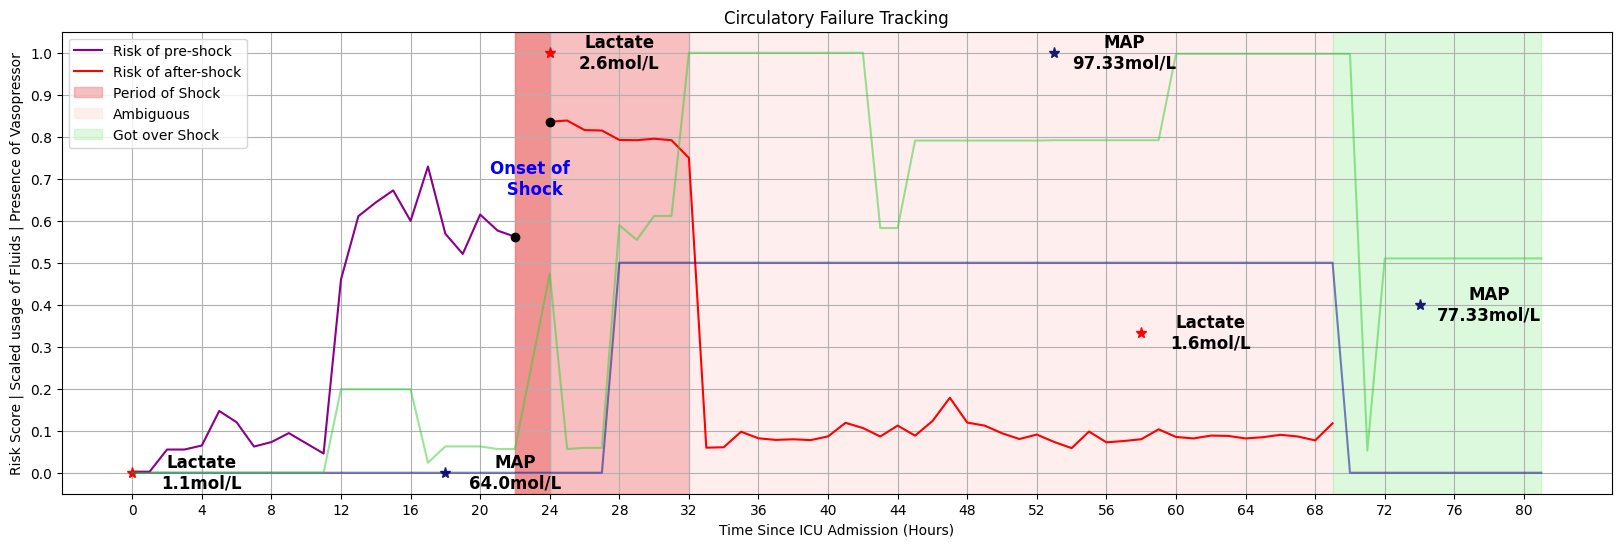

In [513]:
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline, BSpline
interest = output_viz[output_viz['stay_id'] == high_f1_stay_ids[0]]
interest['Fluids(ml)_scaled'], fluids_min, fluids_max = min_max_scaling(interest['Fluids(ml)'], 'none', 'none')

interest['Lactate_scaled'], lactate_min, lactate_max = min_max_scaling(interest['Lactate'], 'none', 'none')
interest['MAP_scaled'], map_min, map_max = min_max_scaling(interest['MAP'], 'none', 'none')

Case1_2 = interest.iloc[:23].drop(index = 15797, axis = 0)
Case3_4 = interest.iloc[23:]

out_of_event = mimic[mimic['stay_id']==36438264][['Time_since_ICU_admission', 'Annotation','Lactate', 'MAP', 'vasoactive/inotropic', 'Fluids(ml)']].sort_values(by=["Time_since_ICU_admission"]).iloc[33:44]
new_row = pd.DataFrame([[70, 'no_circ', 1.6, 83, 0, 238.84]], columns = out_of_event.columns)
out_of_event = pd.concat([new_row, out_of_event.iloc[:]], ignore_index = True)

out_of_event['Lactate_scaled'] = min_max_scaling(out_of_event['Lactate'], lactate_min, lactate_max)
out_of_event['MAP_scaled'] = min_max_scaling(out_of_event['MAP'], map_min, map_max)
out_of_event['Fluids(ml)_scaled'] = min_max_scaling(out_of_event['Fluids(ml)'], fluids_min, fluids_max)

plt.figure(figsize=(20, 6))

onset_of_shock_time = Case1_2['Time_since_ICU_admission'].iloc[-1]+1

# Case1_2
plt.plot(Case1_2['Time_since_ICU_admission'], Case1_2['prediction_prob_case2'], linestyle='-', color='darkmagenta', label='Risk of pre-shock')

# x_MAP = np.linspace(Case1_2['Time_since_ICU_admission'].min(), Case1_2['Time_since_ICU_admission'].max(), 300) 
# spl = make_interp_spline(Case1_2['Time_since_ICU_admission'].values, Case1_2['MAP_scaled'].values, k=3) 
# power_smooth_map = spl(x_MAP)

# plt.plot(x_MAP, power_smooth_map, linestyle='-', color='gray', label='MAP', alpha=0.5)

# x_LACtate = np.linspace(Case1_2['Time_since_ICU_admission'].min(), Case1_2['Time_since_ICU_admission'].max(), 300) 
# spl = make_interp_spline(Case1_2['Time_since_ICU_admission'].values, Case1_2['Lactate_scaled'].values, k=3) 
# power_smooth_lactate = spl(x_LACtate)

# plt.plot(x_LACtate, power_smooth_lactate, linestyle='-', color='darkorange', label='Lactate', alpha=0.5)

# Case3_4
plt.plot(Case3_4['Time_since_ICU_admission'], Case3_4['prediction_prob_case4'], linestyle='-', color='red', label='Risk of after-shock')


# x_MAP = np.linspace(Case3_4['Time_since_ICU_admission'].min(), Case3_4['Time_since_ICU_admission'].max(), 300) 
# spl = make_interp_spline(Case3_4['Time_since_ICU_admission'].values, Case3_4['MAP_scaled'].values, k=3) 
# power_smooth_map = spl(x_MAP)

# plt.plot(x_MAP, power_smooth_map, linestyle='-', color='gray', label='MAP', alpha=0.5)

# x_LACtate = np.linspace(Case3_4['Time_since_ICU_admission'].min(), Case3_4['Time_since_ICU_admission'].max(), 300) 
# spl = make_interp_spline(Case3_4['Time_since_ICU_admission'].values, Case3_4['Lactate_scaled'].values, k=3) 
# power_smooth_lactate = spl(x_LACtate)

# plt.plot(x_LACtate, power_smooth_lactate, linestyle='-', color='darkorange', label='Lactate', alpha=0.5)

# # out_of_event
# out_of_event.index = out_of_event.index + 480637 + 1
# plt.plot(out_of_event['Time_since_ICU_admission'], out_of_event['vasoactive/inotropic']/2, linestyle='-', color='darkblue', alpha=0.5)
# plt.plot(out_of_event['Time_since_ICU_admission'], out_of_event['Fluids(ml)_scaled'], linestyle='-', color='limegreen', alpha=0.5)

# x_MAP = np.linspace(out_of_event['Time_since_ICU_admission'].min(), out_of_event['Time_since_ICU_admission'].max(), 300) 
# spl = make_interp_spline(out_of_event['Time_since_ICU_admission'].values, out_of_event['MAP_scaled'].values, k=3) 
# power_smooth_map = spl(x_MAP)

# plt.plot(x_MAP, power_smooth_map, linestyle='-', color='gray', label='MAP', alpha=0.5)

# x_LACtate = np.linspace(out_of_event['Time_since_ICU_admission'].min(), out_of_event['Time_since_ICU_admission'].max(), 300) 
# spl = make_interp_spline(out_of_event['Time_since_ICU_admission'].values, out_of_event['Lactate_scaled'].values, k=3) 
# power_smooth_lactate = spl(x_LACtate)

# plt.plot(x_LACtate, power_smooth_lactate, linestyle='-', color='darkorange', label='Lactate', alpha=0.5)

tracking_Lactate = pd.concat([interest[out_of_event.columns], out_of_event]).reset_index(drop=True)
idx = tracking_Lactate['Lactate_scaled'].idxmax()
max_lactate = tracking_Lactate['Lactate'].loc[idx]
max_lactate_scaled = tracking_Lactate['Lactate_scaled'].loc[idx]

# marker
plt.plot(tracking_Lactate['Time_since_ICU_admission'].loc[idx], max_lactate_scaled, '*', color='r', markersize=8)
plt.text(tracking_Lactate['Time_since_ICU_admission'].loc[idx] + 4, max_lactate_scaled, f'Lactate\n{max_lactate}mol/L', ha='center', va='center', fontsize=12, color='black', fontweight='bold')

min_idx = tracking_Lactate['Lactate_scaled'].idxmin()
min_lactate = tracking_Lactate['Lactate'].loc[min_idx]
min_lactate_scaled = tracking_Lactate['Lactate_scaled'].loc[min_idx]

# marker
plt.plot(tracking_Lactate['Time_since_ICU_admission'].loc[min_idx], min_lactate_scaled, '*', color='r', markersize=8)
plt.text(tracking_Lactate['Time_since_ICU_admission'].loc[min_idx] + 4, min_lactate_scaled, f'Lactate\n{min_lactate}mol/L', ha='center', va='center', fontsize=12, color='black', fontweight='bold')

median_lactate_scaled = tracking_Lactate.median()['Lactate_scaled']
median_lactate = tracking_Lactate.median()['Lactate']
median_idx = tracking_Lactate[tracking_Lactate['Lactate'] == median_lactate].index.min()

# marker
plt.plot(tracking_Lactate['Time_since_ICU_admission'].loc[median_idx], median_lactate_scaled, '*', color='r', markersize=8)
plt.text(tracking_Lactate['Time_since_ICU_admission'].loc[median_idx] + 4, median_lactate_scaled, f'Lactate\n{median_lactate}mol/L', ha='center', va='center', fontsize=12, color='black', fontweight='bold')

# MAP -------------
idx = tracking_Lactate['MAP_scaled'].idxmax()
max_lactate = tracking_Lactate['MAP'].loc[idx]
max_lactate_scaled = tracking_Lactate['MAP_scaled'].loc[idx]

# marker
plt.plot(tracking_Lactate['Time_since_ICU_admission'].loc[idx], max_lactate_scaled, '*', color='midnightblue', markersize=8)
plt.text(tracking_Lactate['Time_since_ICU_admission'].loc[idx] + 4, max_lactate_scaled, f'MAP\n{np.round(max_lactate, 2)}mol/L', ha='center', va='center', fontsize=12, color='black', fontweight='bold')

min_idx = tracking_Lactate['MAP_scaled'].idxmin()
min_lactate = tracking_Lactate['MAP'].loc[min_idx]
min_lactate_scaled = tracking_Lactate['MAP_scaled'].loc[min_idx]

# marker
plt.plot(tracking_Lactate['Time_since_ICU_admission'].loc[min_idx], min_lactate_scaled, '*', color='midnightblue', markersize=8)
plt.text(tracking_Lactate['Time_since_ICU_admission'].loc[min_idx] + 4, min_lactate_scaled, f'MAP\n{np.round(min_lactate, 2)}mol/L', ha='center', va='center', fontsize=12, color='black', fontweight='bold')

median_lactate_scaled = tracking_Lactate.median()['MAP_scaled']
median_lactate = tracking_Lactate.median()['MAP']
median_idx = tracking_Lactate[tracking_Lactate['MAP'] == median_lactate].index.min()

# marker
plt.plot(tracking_Lactate['Time_since_ICU_admission'].loc[median_idx], median_lactate_scaled, '*', color='midnightblue', markersize=8)
plt.text(tracking_Lactate['Time_since_ICU_admission'].loc[median_idx] + 4, median_lactate_scaled, f'MAP\n{np.round(median_lactate, 2)}mol/L', ha='center', va='center', fontsize=12, color='black', fontweight='bold')

# out_of_event
# out_of_event.index = out_of_event.index + 480637 + 1
plt.plot(tracking_Lactate['Time_since_ICU_admission'], tracking_Lactate['vasoactive/inotropic']/2, linestyle='-', color='darkblue', alpha=0.5)
plt.plot(tracking_Lactate['Time_since_ICU_admission'], tracking_Lactate['Fluids(ml)_scaled'], linestyle='-', color='limegreen', alpha=0.5)

# marker
plt.plot([Case1_2['Time_since_ICU_admission'].iloc[-1], Case3_4['Time_since_ICU_admission'].iloc[0]], [Case1_2['prediction_prob_case2'].iloc[-1], Case3_4['prediction_prob_case4'].iloc[0]], 'o', color='black')

plt.axvspan(onset_of_shock_time-1, onset_of_shock_time+1, color='lightcoral', alpha=0.7)
plt.axvspan(onset_of_shock_time-1, onset_of_shock_time+9, color='lightcoral', alpha=0.5, label='Period of Shock')
plt.axvspan(onset_of_shock_time+9, onset_of_shock_time+9+37, color='mistyrose', alpha=0.6, label='Ambiguous')
plt.axvspan(onset_of_shock_time+9+37, onset_of_shock_time+9+37+12, color='lightgreen', alpha=0.3, label='Got over Shock')

plt.text(onset_of_shock_time, 0.5 * (Case1_2['prediction_prob_case2'].iloc[-1] + Case3_4['prediction_prob_case4'].iloc[0]), 'Onset of \n Shock', ha='center', va='center', fontsize=12, color='blue', fontweight='bold')

xmin, xmax = 0, 81 
plt.xticks(range(xmin, xmax + 1, 4))

ymin, ymax = 0, 1 
plt.yticks(np.arange(ymin, ymax + 0.1, 0.1))

plt.title('Circulatory Failure Tracking')
plt.xlabel('Time Since ICU Admission (Hours)')
plt.ylabel('Risk Score | Scaled usage of Fluids | Presence of Vasopressor')

plt.grid(True)
plt.legend(loc = 'upper left')
plt.show()

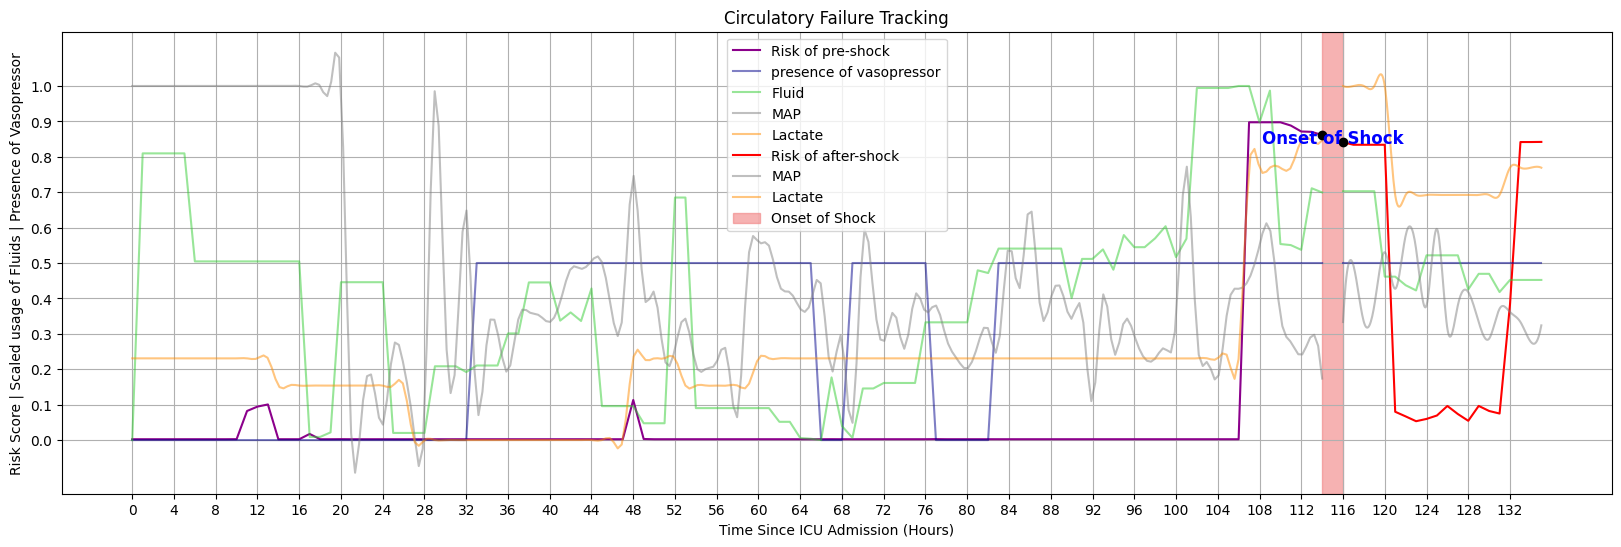

In [357]:
import matplotlib.pyplot as plt
interest = output_viz[output_viz['stay_id'] == high_f1_stay_ids[3]]
interest['Fluids(ml)_scaled'] = min_max_scaling(interest['Fluids(ml)'])
interest['Lactate_scaled'] = min_max_scaling(interest['Lactate'])
interest['MAP_scaled'] = min_max_scaling(interest['MAP'])

Case1_2 = interest.iloc[:115]
Case3_4 = interest.iloc[115:]

plt.figure(figsize=(20, 6))

onset_of_shock_time = Case1_2['Time_since_ICU_admission'].iloc[-1]+1

# Case1_2
plt.plot(Case1_2['Time_since_ICU_admission'], Case1_2['prediction_prob_case2'], linestyle='-', color='darkmagenta', label='Risk of pre-shock')
plt.plot(Case1_2['Time_since_ICU_admission'], Case1_2['vasoactive/inotropic']/2, linestyle='-', color='darkblue', label='presence of vasopressor', alpha=0.5)
plt.plot(Case1_2['Time_since_ICU_admission'], Case1_2['Fluids(ml)_scaled'], linestyle='-', color='limegreen', label='Fluid', alpha=0.5)

x_MAP = np.linspace(Case1_2['Time_since_ICU_admission'].min(), Case1_2['Time_since_ICU_admission'].max(), 300) 
spl = make_interp_spline(Case1_2['Time_since_ICU_admission'].values, Case1_2['MAP_scaled'].values, k=3) 
power_smooth_map = spl(x_MAP)

plt.plot(x_MAP, power_smooth_map, linestyle='-', color='gray', label='MAP', alpha=0.5)

x_LACtate = np.linspace(Case1_2['Time_since_ICU_admission'].min(), Case1_2['Time_since_ICU_admission'].max(), 300) 
spl = make_interp_spline(Case1_2['Time_since_ICU_admission'].values, Case1_2['Lactate_scaled'].values, k=3) 
power_smooth_lactate = spl(x_LACtate)

plt.plot(x_LACtate, power_smooth_lactate, linestyle='-', color='darkorange', label='Lactate', alpha=0.5)

# Case3_4
plt.plot(Case3_4['Time_since_ICU_admission'], Case3_4['prediction_prob_case4'], linestyle='-', color='red', label='Risk of after-shock')
plt.plot(Case3_4['Time_since_ICU_admission'], Case3_4['vasoactive/inotropic']/2, linestyle='-', color='darkblue', alpha=0.5)
plt.plot(Case3_4['Time_since_ICU_admission'], Case3_4['Fluids(ml)_scaled'], linestyle='-', color='limegreen', alpha=0.5)

x_MAP = np.linspace(Case3_4['Time_since_ICU_admission'].min(), Case3_4['Time_since_ICU_admission'].max(), 300) 
spl = make_interp_spline(Case3_4['Time_since_ICU_admission'].values, Case3_4['MAP_scaled'].values, k=3) 
power_smooth_map = spl(x_MAP)

plt.plot(x_MAP, power_smooth_map, linestyle='-', color='gray', label='MAP', alpha=0.5)

x_LACtate = np.linspace(Case3_4['Time_since_ICU_admission'].min(), Case3_4['Time_since_ICU_admission'].max(), 300) 
spl = make_interp_spline(Case3_4['Time_since_ICU_admission'].values, Case3_4['Lactate_scaled'].values, k=3) 
power_smooth_lactate = spl(x_LACtate)

plt.plot(x_LACtate, power_smooth_lactate, linestyle='-', color='darkorange', label='Lactate', alpha=0.5)

# marker
plt.plot([Case1_2['Time_since_ICU_admission'].iloc[-1], Case3_4['Time_since_ICU_admission'].iloc[0]], [Case1_2['prediction_prob_case2'].iloc[-1], Case3_4['prediction_prob_case4'].iloc[0]], 'o', color='black')


plt.axvspan(onset_of_shock_time-1, onset_of_shock_time+1, color='lightcoral', alpha=0.6, label='Onset of Shock')
plt.text(onset_of_shock_time, 0.5 * (Case1_2['prediction_prob_case2'].iloc[-1] + Case3_4['prediction_prob_case4'].iloc[0]), 'Onset of Shock', ha='center', va='center', fontsize=12, color='blue', fontweight='bold')

xmin, xmax = 0, 135 
plt.xticks(range(xmin, xmax + 1, 4))

ymin, ymax = 0, 1 
plt.yticks(np.arange(ymin, ymax + 0.1, 0.1))

plt.title('Circulatory Failure Tracking')
plt.xlabel('Time Since ICU Admission (Hours)')
plt.ylabel('Risk Score | Scaled usage of Fluids | Presence of Vasopressor')

plt.grid(True)
plt.legend()
plt.show()

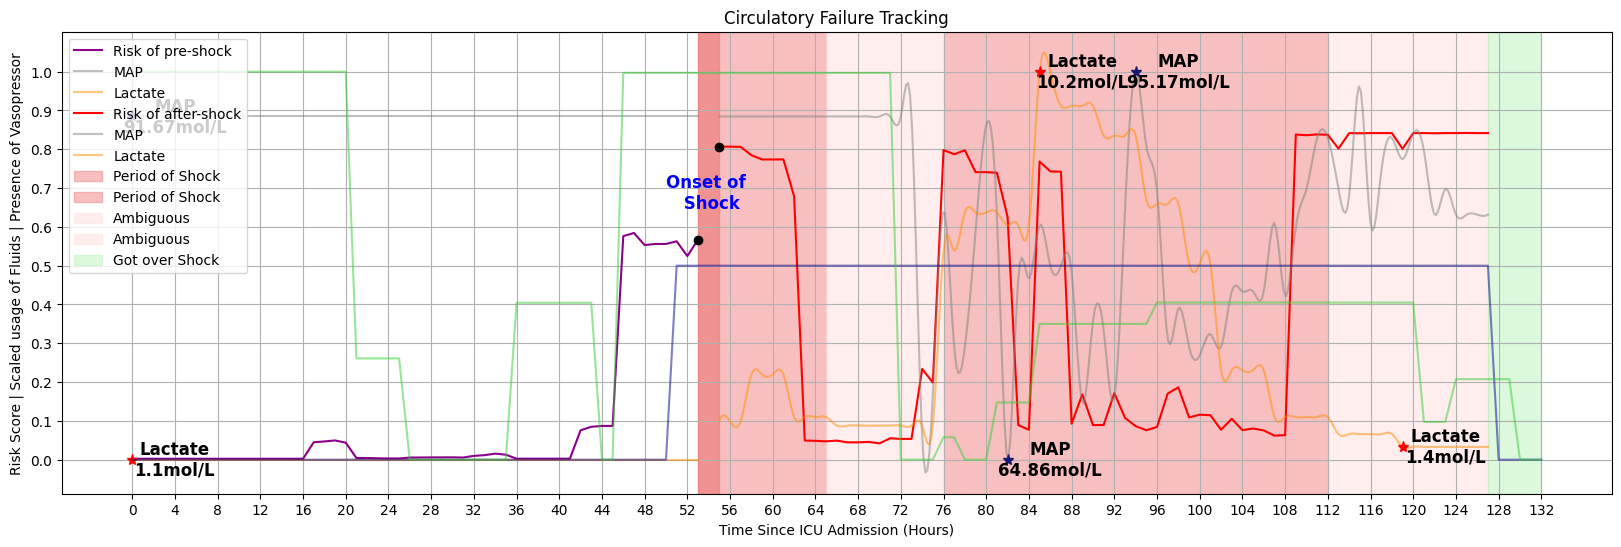

In [597]:
#failure case Lactate, MAP 가 모두 정상화 되었지만, 높은 risk score를 가지고 있음


import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline, BSpline
interest = output_viz[output_viz['stay_id'] == high_f1_stay_ids[2]]
interest['Fluids(ml)_scaled'], fluids_min, fluids_max = min_max_scaling(interest['Fluids(ml)'], 'none', 'none')

interest['Lactate_scaled'], lactate_min, lactate_max = min_max_scaling(interest['Lactate'], 'none', 'none')
interest['MAP_scaled'], map_min, map_max = min_max_scaling(interest['MAP'], 'none', 'none')

Case1_2 = interest.iloc[:54]
Case3_4 = interest.iloc[54:]

out_of_event = mimic[mimic['stay_id']==37545217][['Time_since_ICU_admission', 'Annotation','Lactate', 'MAP', 'vasoactive/inotropic', 'Fluids(ml)']].sort_values(by=["Time_since_ICU_admission"]).iloc[-4:]
new_row = pd.DataFrame([[128, 'no_circ', 1.4, 84, 0, 518519.39959]], columns = out_of_event.columns)
out_of_event = pd.concat([new_row, out_of_event.iloc[:]], ignore_index = True)

out_of_event['Lactate_scaled'] = min_max_scaling(out_of_event['Lactate'], lactate_min, lactate_max)
out_of_event['MAP_scaled'] = min_max_scaling(out_of_event['MAP'], map_min, map_max)
out_of_event['Fluids(ml)_scaled'] = min_max_scaling(out_of_event['Fluids(ml)'], fluids_min, fluids_max)

plt.figure(figsize=(20, 6))

onset_of_shock_time = Case1_2['Time_since_ICU_admission'].iloc[-1]+1

# Case1_2
plt.plot(Case1_2['Time_since_ICU_admission'], Case1_2['prediction_prob_case2'], linestyle='-', color='darkmagenta', label='Risk of pre-shock')


x_MAP = np.linspace(Case1_2['Time_since_ICU_admission'].min(), Case1_2['Time_since_ICU_admission'].max(), 400) 
spl = make_interp_spline(Case1_2['Time_since_ICU_admission'].values, Case1_2['MAP_scaled'].values, k=3) 
power_smooth_map = spl(x_MAP)

plt.plot(x_MAP, power_smooth_map, linestyle='-', color='gray', label='MAP', alpha=0.5)

x_LACtate = np.linspace(Case1_2['Time_since_ICU_admission'].min(), Case1_2['Time_since_ICU_admission'].max(), 400) 
spl = make_interp_spline(Case1_2['Time_since_ICU_admission'].values, Case1_2['Lactate_scaled'].values, k=3) 
power_smooth_lactate = spl(x_LACtate)

plt.plot(x_LACtate, power_smooth_lactate, linestyle='-', color='darkorange', label='Lactate', alpha=0.5)


# Case3_4
plt.plot(Case3_4['Time_since_ICU_admission'], Case3_4['prediction_prob_case4'], linestyle='-', color='red', label='Risk of after-shock')

x_MAP = np.linspace(Case3_4['Time_since_ICU_admission'].min(), Case3_4['Time_since_ICU_admission'].max(), 400) 
spl = make_interp_spline(Case3_4['Time_since_ICU_admission'].values, Case3_4['MAP_scaled'].values, k=3) 
power_smooth_map = spl(x_MAP)

plt.plot(x_MAP, power_smooth_map, linestyle='-', color='gray', label='MAP', alpha=0.5)

x_LACtate = np.linspace(Case3_4['Time_since_ICU_admission'].min(), Case3_4['Time_since_ICU_admission'].max(), 400) 
spl = make_interp_spline(Case3_4['Time_since_ICU_admission'].values, Case3_4['Lactate_scaled'].values, k=3) 
power_smooth_lactate = spl(x_LACtate)

plt.plot(x_LACtate, power_smooth_lactate, linestyle='-', color='darkorange', label='Lactate', alpha=0.5)

# tracking
tracking_Lactate = pd.concat([interest[out_of_event.columns], out_of_event]).reset_index(drop=True)
idx = tracking_Lactate['Lactate_scaled'].idxmax()
max_lactate = tracking_Lactate['Lactate'].loc[idx]
max_lactate_scaled = tracking_Lactate['Lactate_scaled'].loc[idx]

# marker
plt.plot(tracking_Lactate['Time_since_ICU_admission'].loc[idx], max_lactate_scaled, '*', color='r', markersize=8)
plt.text(tracking_Lactate['Time_since_ICU_admission'].loc[idx] + 4, max_lactate_scaled, f'Lactate\n{max_lactate}mol/L', ha='center', va='center', fontsize=12, color='black', fontweight='bold')

min_idx = tracking_Lactate['Lactate_scaled'].idxmin()
min_lactate = tracking_Lactate['Lactate'].loc[min_idx]
min_lactate_scaled = tracking_Lactate['Lactate_scaled'].loc[min_idx]

# marker
plt.plot(tracking_Lactate['Time_since_ICU_admission'].loc[min_idx], min_lactate_scaled, '*', color='r', markersize=8)
plt.text(tracking_Lactate['Time_since_ICU_admission'].loc[min_idx] + 4, min_lactate_scaled, f'Lactate\n{min_lactate}mol/L', ha='center', va='center', fontsize=12, color='black', fontweight='bold')

median_lactate_scaled = tracking_Lactate.median()['Lactate_scaled']
median_lactate = tracking_Lactate.median()['Lactate']
median_idx = tracking_Lactate[tracking_Lactate['Lactate'] == median_lactate].index.min()

# marker
plt.plot(tracking_Lactate['Time_since_ICU_admission'].loc[median_idx], median_lactate_scaled, '*', color='r', markersize=8)
plt.text(tracking_Lactate['Time_since_ICU_admission'].loc[median_idx] + 4, median_lactate_scaled, f'Lactate\n{median_lactate}mol/L', ha='center', va='center', fontsize=12, color='black', fontweight='bold')

# MAP -------------
idx = tracking_Lactate['MAP_scaled'].idxmax()
max_lactate = tracking_Lactate['MAP'].loc[idx]
max_lactate_scaled = tracking_Lactate['MAP_scaled'].loc[idx]

# marker
plt.plot(tracking_Lactate['Time_since_ICU_admission'].loc[idx], max_lactate_scaled, '*', color='midnightblue', markersize=8)
plt.text(tracking_Lactate['Time_since_ICU_admission'].loc[idx] + 4, max_lactate_scaled, f'MAP\n{np.round(max_lactate, 2)}mol/L', ha='center', va='center', fontsize=12, color='black', fontweight='bold')

min_idx = tracking_Lactate['MAP_scaled'].idxmin()
min_lactate = tracking_Lactate['MAP'].loc[min_idx]
min_lactate_scaled = tracking_Lactate['MAP_scaled'].loc[min_idx]

# marker
plt.plot(tracking_Lactate['Time_since_ICU_admission'].loc[min_idx], min_lactate_scaled, '*', color='midnightblue', markersize=8)
plt.text(tracking_Lactate['Time_since_ICU_admission'].loc[min_idx] + 4, min_lactate_scaled, f'MAP\n{np.round(min_lactate, 2)}mol/L', ha='center', va='center', fontsize=12, color='black', fontweight='bold')

median_lactate_scaled = tracking_Lactate.median()['MAP_scaled']
median_lactate = tracking_Lactate.median()['MAP']
median_idx = tracking_Lactate[tracking_Lactate['MAP'] == median_lactate].index.min()

# marker
plt.plot(tracking_Lactate['Time_since_ICU_admission'].loc[median_idx], median_lactate_scaled, '*', color='midnightblue', markersize=8)
plt.text(tracking_Lactate['Time_since_ICU_admission'].loc[median_idx] + 4, median_lactate_scaled, f'MAP\n{np.round(median_lactate, 2)}mol/L', ha='center', va='center', fontsize=12, color='black', fontweight='bold')

# out_of_event
# out_of_event.index = out_of_event.index + 480637 + 1
plt.plot(tracking_Lactate['Time_since_ICU_admission'], tracking_Lactate['vasoactive/inotropic']/2, linestyle='-', color='darkblue', alpha=0.5)
plt.plot(tracking_Lactate['Time_since_ICU_admission'], tracking_Lactate['Fluids(ml)_scaled'], linestyle='-', color='limegreen', alpha=0.5)

# marker
plt.plot([Case1_2['Time_since_ICU_admission'].iloc[-1], Case3_4['Time_since_ICU_admission'].iloc[0]], [Case1_2['prediction_prob_case2'].iloc[-1], Case3_4['prediction_prob_case4'].iloc[0]], 'o', color='black')

plt.axvspan(onset_of_shock_time-1, onset_of_shock_time+1, color='lightcoral', alpha=0.7)
plt.axvspan(onset_of_shock_time-1, onset_of_shock_time+11, color='lightcoral', alpha=0.5, label='Period of Shock')
plt.axvspan(onset_of_shock_time+22, onset_of_shock_time+58, color='lightcoral', alpha=0.5, label='Period of Shock')
plt.axvspan(onset_of_shock_time+11, onset_of_shock_time+22, color='mistyrose', alpha=0.6, label='Ambiguous')
plt.axvspan(onset_of_shock_time+58, onset_of_shock_time+73, color='mistyrose', alpha=0.6, label='Ambiguous')
plt.axvspan(onset_of_shock_time+73, onset_of_shock_time+78, color='lightgreen', alpha=0.3, label='Got over Shock')

plt.text(onset_of_shock_time, 0.5 * (Case1_2['prediction_prob_case2'].iloc[-1] + Case3_4['prediction_prob_case4'].iloc[0]), 'Onset of \n Shock', ha='center', va='center', fontsize=12, color='blue', fontweight='bold')

xmin, xmax = 0, 132 
plt.xticks(range(xmin, xmax + 1, 4))

ymin, ymax = 0, 1 
plt.yticks(np.arange(ymin, ymax + 0.1, 0.1))

plt.title('Circulatory Failure Tracking')
plt.xlabel('Time Since ICU Admission (Hours)')
plt.ylabel('Risk Score | Scaled usage of Fluids | Presence of Vasopressor')

plt.grid(True)
plt.legend(loc = 'upper left')
plt.show()

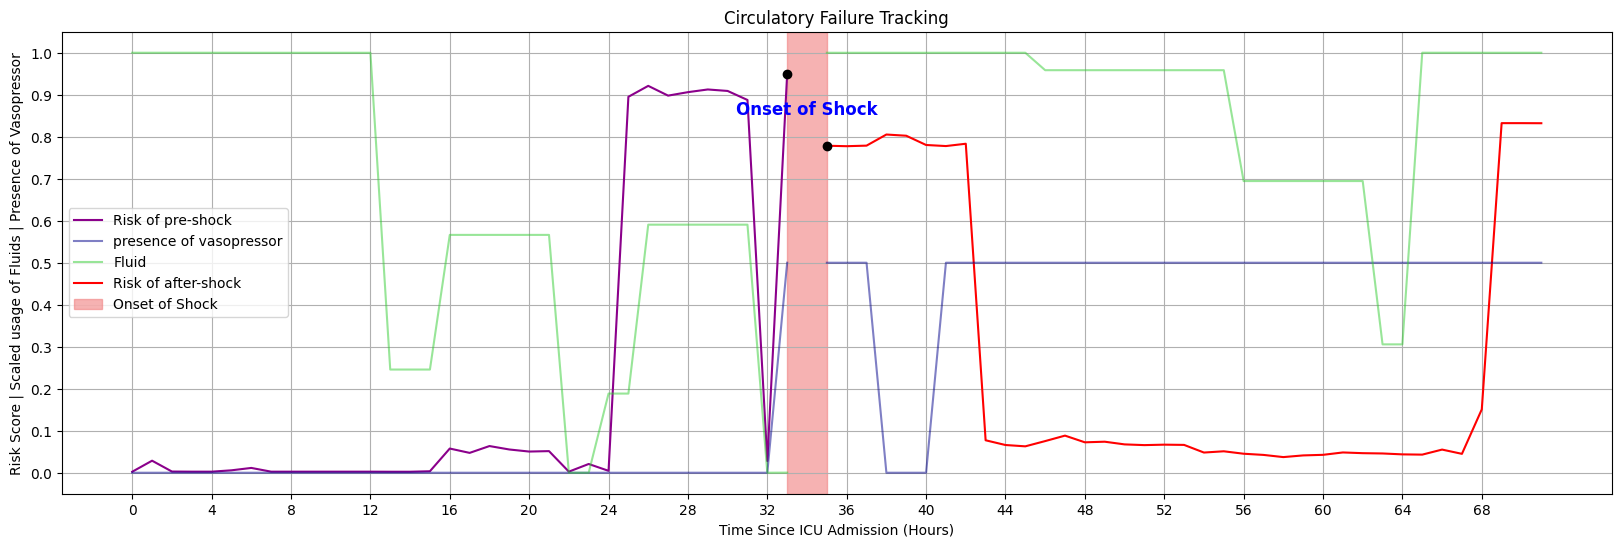

In [593]:
import matplotlib.pyplot as plt
interest = output_viz[output_viz['stay_id'] == high_f1_stay_ids[10]]
interest['Fluids(ml)_scaled'], fluids_min, fluids_max = min_max_scaling(interest['Fluids(ml)'], 'none', 'none')
interest['Lactate_scaled'], lactate_min, lactate_max = min_max_scaling(interest['Lactate'], 'none', 'none')
interest['MAP_scaled'], map_min, map_max = min_max_scaling(interest['MAP'], 'none', 'none')

Case1_2 = interest.iloc[:34]
Case3_4 = interest.iloc[34:]

plt.figure(figsize=(20, 6))

onset_of_shock_time = Case1_2['Time_since_ICU_admission'].iloc[-1]+1

# Case1_2
plt.plot(Case1_2['Time_since_ICU_admission'], Case1_2['prediction_prob_case2'], linestyle='-', color='darkmagenta', label='Risk of pre-shock')
plt.plot(Case1_2['Time_since_ICU_admission'], Case1_2['vasoactive/inotropic']/2, linestyle='-', color='darkblue', label='presence of vasopressor', alpha=0.5)
plt.plot(Case1_2['Time_since_ICU_admission'], Case1_2['Fluids(ml)_scaled'], linestyle='-', color='limegreen', label='Fluid', alpha=0.5)

# x_MAP = np.linspace(Case1_2['Time_since_ICU_admission'].min(), Case1_2['Time_since_ICU_admission'].max(), 300) 
# spl = make_interp_spline(Case1_2['Time_since_ICU_admission'].values, Case1_2['MAP_scaled'].values, k=3) 
# power_smooth_map = spl(x_MAP)

# plt.plot(x_MAP, power_smooth_map, linestyle='-', color='gray', label='MAP', alpha=0.5)

# x_LACtate = np.linspace(Case1_2['Time_since_ICU_admission'].min(), Case1_2['Time_since_ICU_admission'].max(), 300) 
# spl = make_interp_spline(Case1_2['Time_since_ICU_admission'].values, Case1_2['Lactate_scaled'].values, k=3) 
# power_smooth_lactate = spl(x_LACtate)

# plt.plot(x_LACtate, power_smooth_lactate, linestyle='-', color='darkorange', label='Lactate', alpha=0.5)

# Case3_4
plt.plot(Case3_4['Time_since_ICU_admission'], Case3_4['prediction_prob_case4'], linestyle='-', color='red', label='Risk of after-shock')
plt.plot(Case3_4['Time_since_ICU_admission'], Case3_4['vasoactive/inotropic']/2, linestyle='-', color='darkblue', alpha=0.5)
plt.plot(Case3_4['Time_since_ICU_admission'], Case3_4['Fluids(ml)_scaled'], linestyle='-', color='limegreen', alpha=0.5)

# x_MAP = np.linspace(Case3_4['Time_since_ICU_admission'].min(), Case3_4['Time_since_ICU_admission'].max(), 300) 
# spl = make_interp_spline(Case3_4['Time_since_ICU_admission'].values, Case3_4['MAP_scaled'].values, k=3) 
# power_smooth_map = spl(x_MAP)

# plt.plot(x_MAP, power_smooth_map, linestyle='-', color='gray', label='MAP', alpha=0.5)

# x_LACtate = np.linspace(Case3_4['Time_since_ICU_admission'].min(), Case3_4['Time_since_ICU_admission'].max(), 300) 
# spl = make_interp_spline(Case3_4['Time_since_ICU_admission'].values, Case3_4['Lactate_scaled'].values, k=3) 
# power_smooth_lactate = spl(x_LACtate)

# plt.plot(x_LACtate, power_smooth_lactate, linestyle='-', color='darkorange', label='Lactate', alpha=0.5)

# marker
plt.plot([Case1_2['Time_since_ICU_admission'].iloc[-1], Case3_4['Time_since_ICU_admission'].iloc[0]], [Case1_2['prediction_prob_case2'].iloc[-1], Case3_4['prediction_prob_case4'].iloc[0]], 'o', color='black')


plt.axvspan(onset_of_shock_time-1, onset_of_shock_time+1, color='lightcoral', alpha=0.6, label='Onset of Shock')
plt.text(onset_of_shock_time, 0.5 * (Case1_2['prediction_prob_case2'].iloc[-1] + Case3_4['prediction_prob_case4'].iloc[0]), 'Onset of Shock', ha='center', va='center', fontsize=12, color='blue', fontweight='bold')

xmin, xmax = 0, 71 
plt.xticks(range(xmin, xmax + 1, 4))

ymin, ymax = 0, 1 
plt.yticks(np.arange(ymin, ymax + 0.1, 0.1))

plt.title('Circulatory Failure Tracking')
plt.xlabel('Time Since ICU Admission (Hours)')
plt.ylabel('Risk Score | Scaled usage of Fluids | Presence of Vasopressor')

plt.grid(True)
plt.legend()
plt.show()